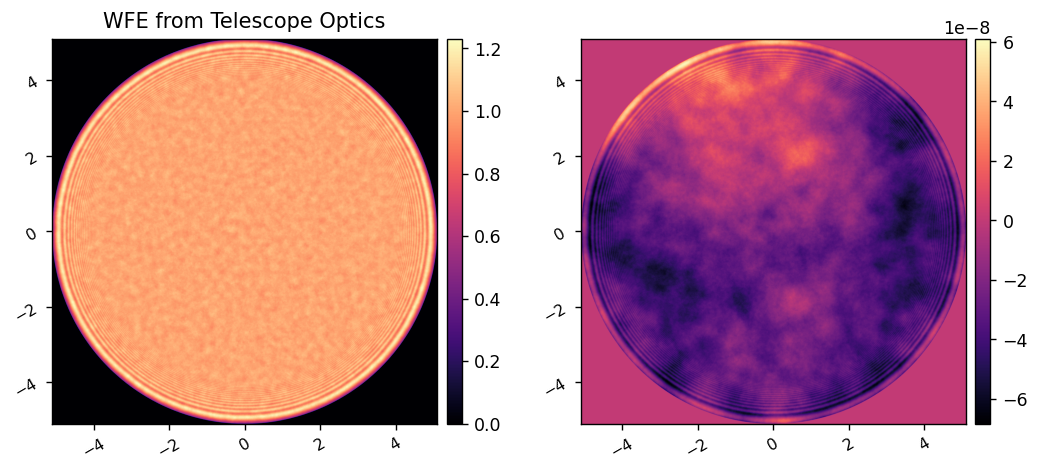

In [2]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
xp = cp if poppy.accel_math._USE_CUPY else np

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

from prop_models import full
reload(full)

from imshows import *
import misc

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

ote_wfe_fname = 'ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 'WFE from Telescope Optics', pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix))

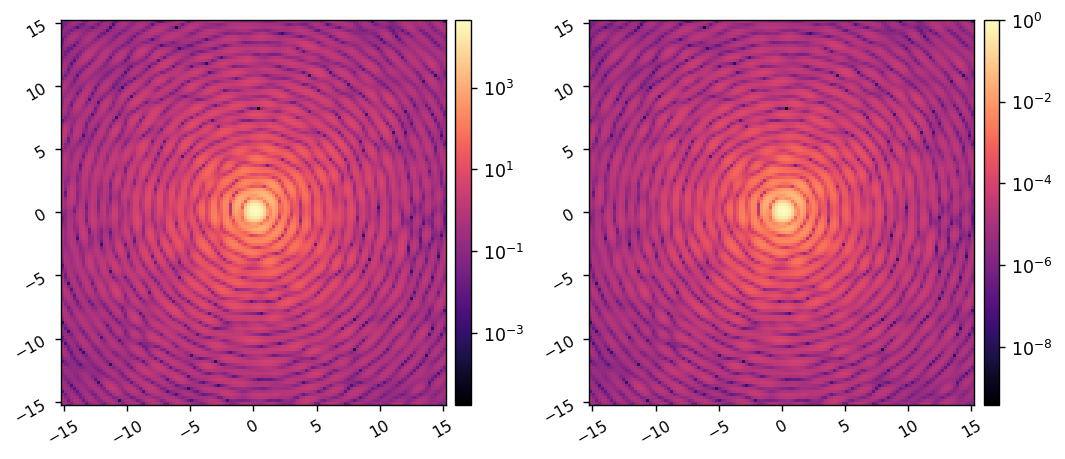

In [10]:
reload(full)
poppy_log.disabled = True

c = full.CORO()

c.npix = 1024
c.oversample = 4
c.npsf = 128

c.use_opds = True
c.OTEWFE = OTE_WFE

image = c.snap()
c.im_norm = image.max()

normalized_image = c.snap()
imshow2(image, normalized_image, pxscl=c.psf_pixelscale_lamD, lognorm=True)




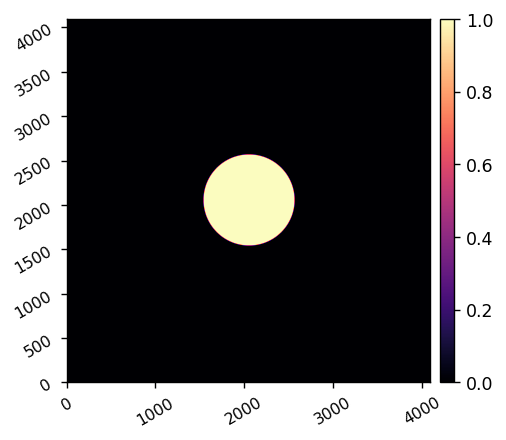

In [11]:
imshow1(c.pupil_mask)

In [19]:
c.pupil_mask.shape

(4096, 4096)

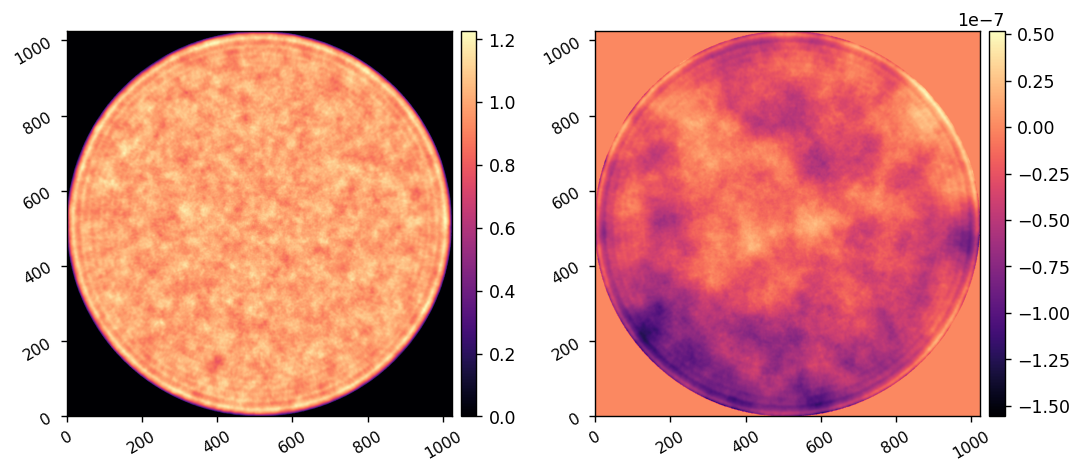

Saved data to:  phase-retrieval-data/post_fpm_pupil_wfe.fits


In [19]:
c.image_pupil = True
pupil_wf = c.calc_pupil()
pupil_amp = xp.rot90( misc.pad_or_crop(xp.abs(pupil_wf)*c.pupil_mask, c.npix), 2)
pupil_phs = xp.rot90( misc.pad_or_crop(xp.angle(pupil_wf)*c.pupil_mask, c.npix), 2)
pupil_opd = pupil_phs * wavelength_c.to_value(u.m)/(2*np.pi)
imshow2(pupil_amp, pupil_opd, )

pxscl = pupil_diam.to_value(u.m)/c.npix



data = misc.ensure_np_array(xp.array([pupil_amp,pupil_opd]))
misc.save_fits('phase-retrieval-data/post_fpm_pupil_wfe.fits', data=data, 
               header={'PIXELSCL':pxscl})